In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.model.regression_model import RegressionModel
from data.io import Reader, Saver
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Загружаем данные
df = Reader.read_csv('./dataset/df_elite.csv')


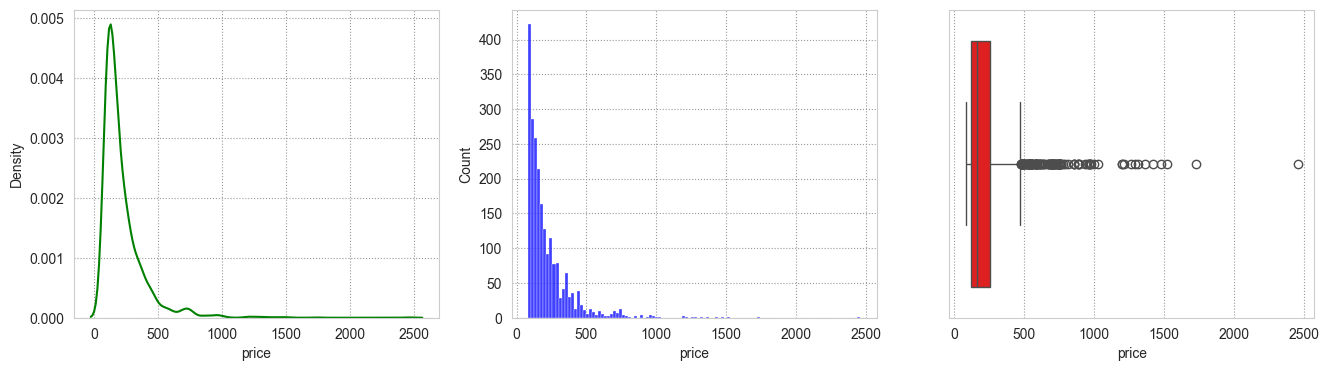

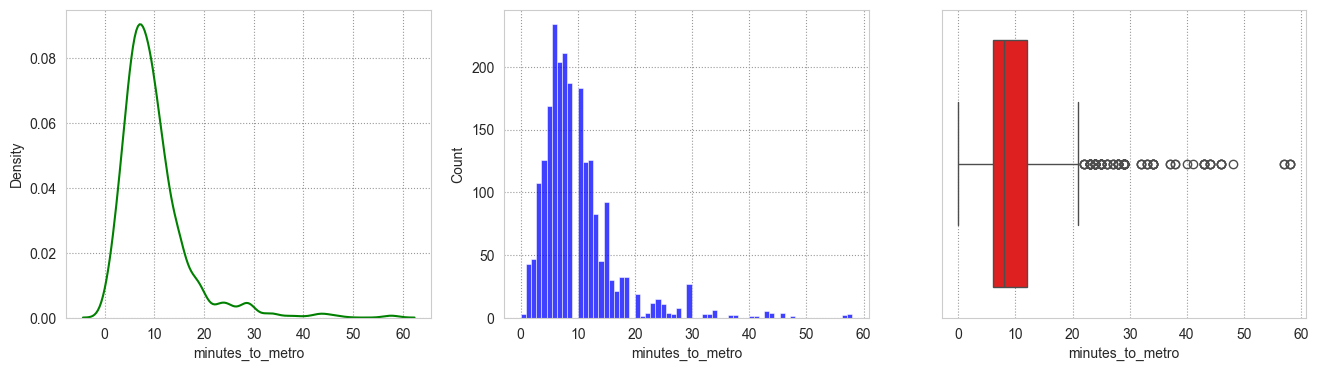

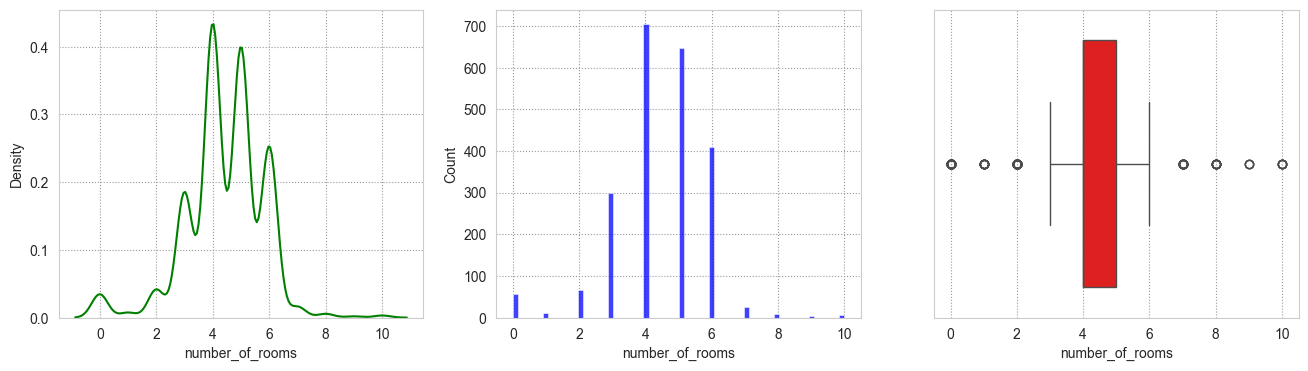

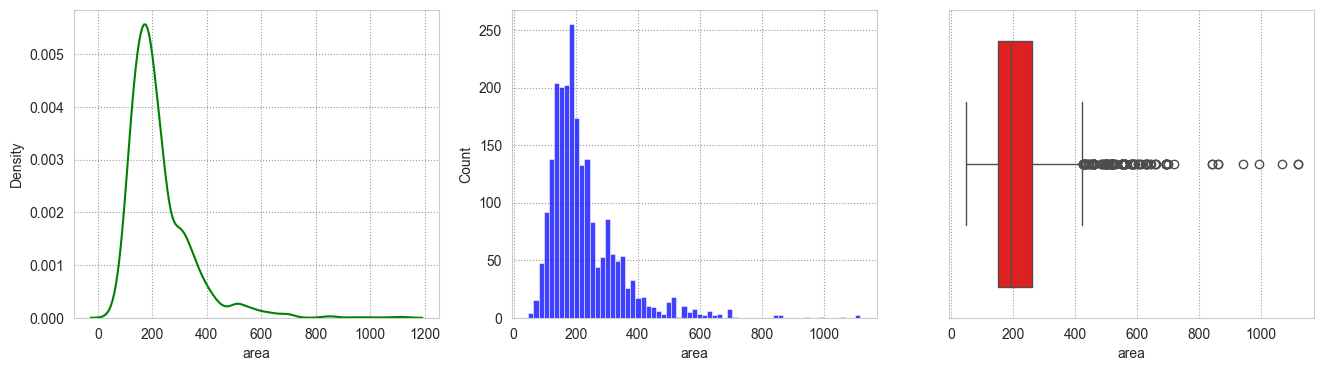

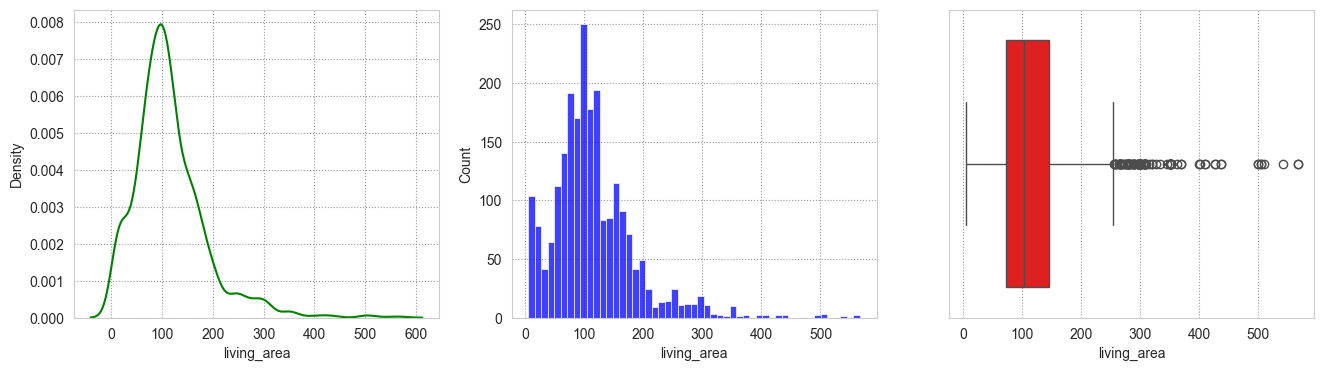

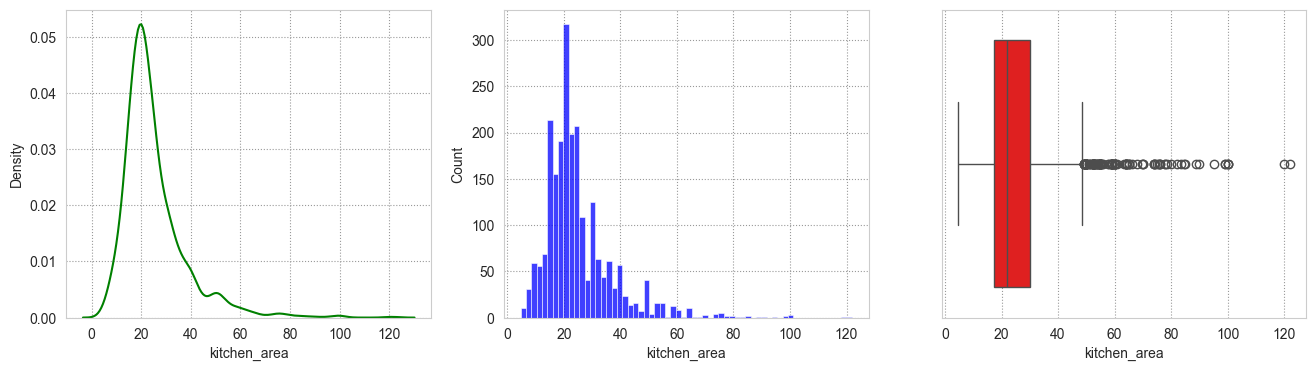

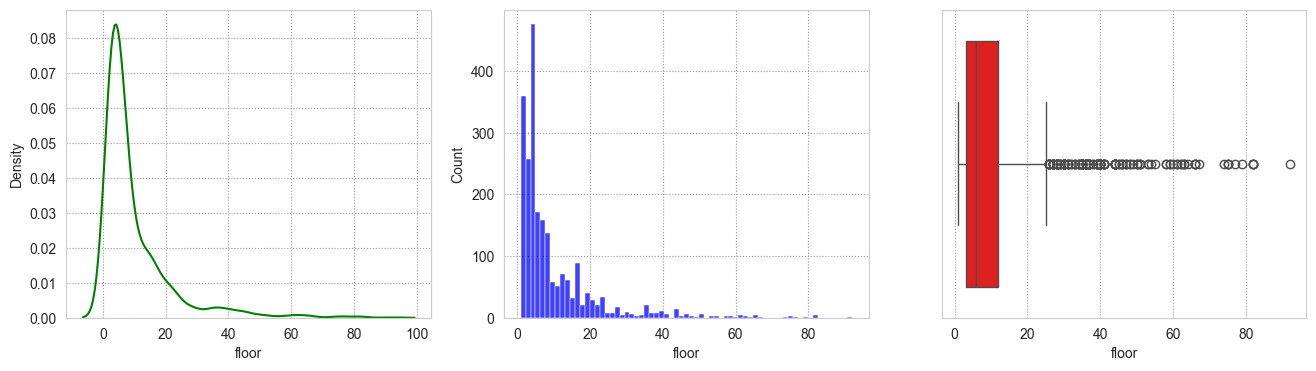

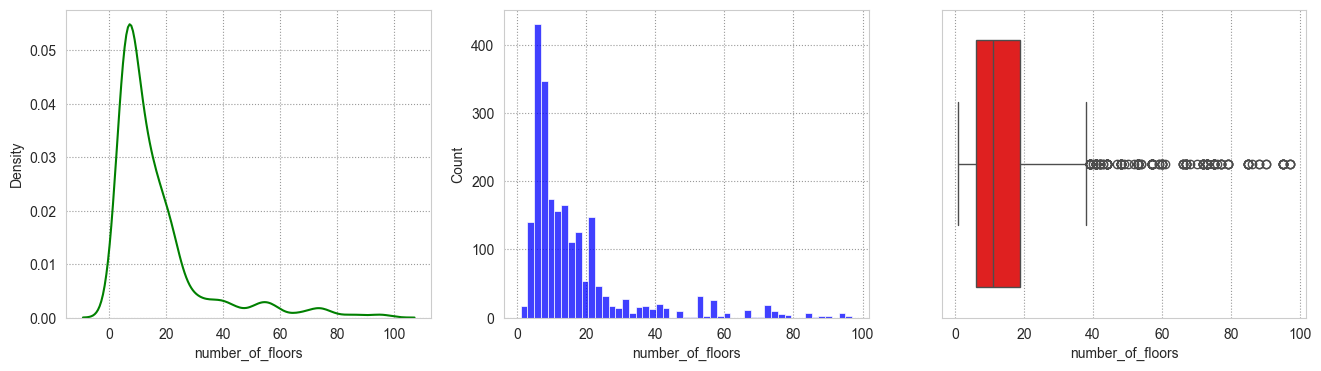

In [3]:
# ещё раз визуально оцениваем обычную недвижимость
Drawer.plot_numeric_seaborn(df)

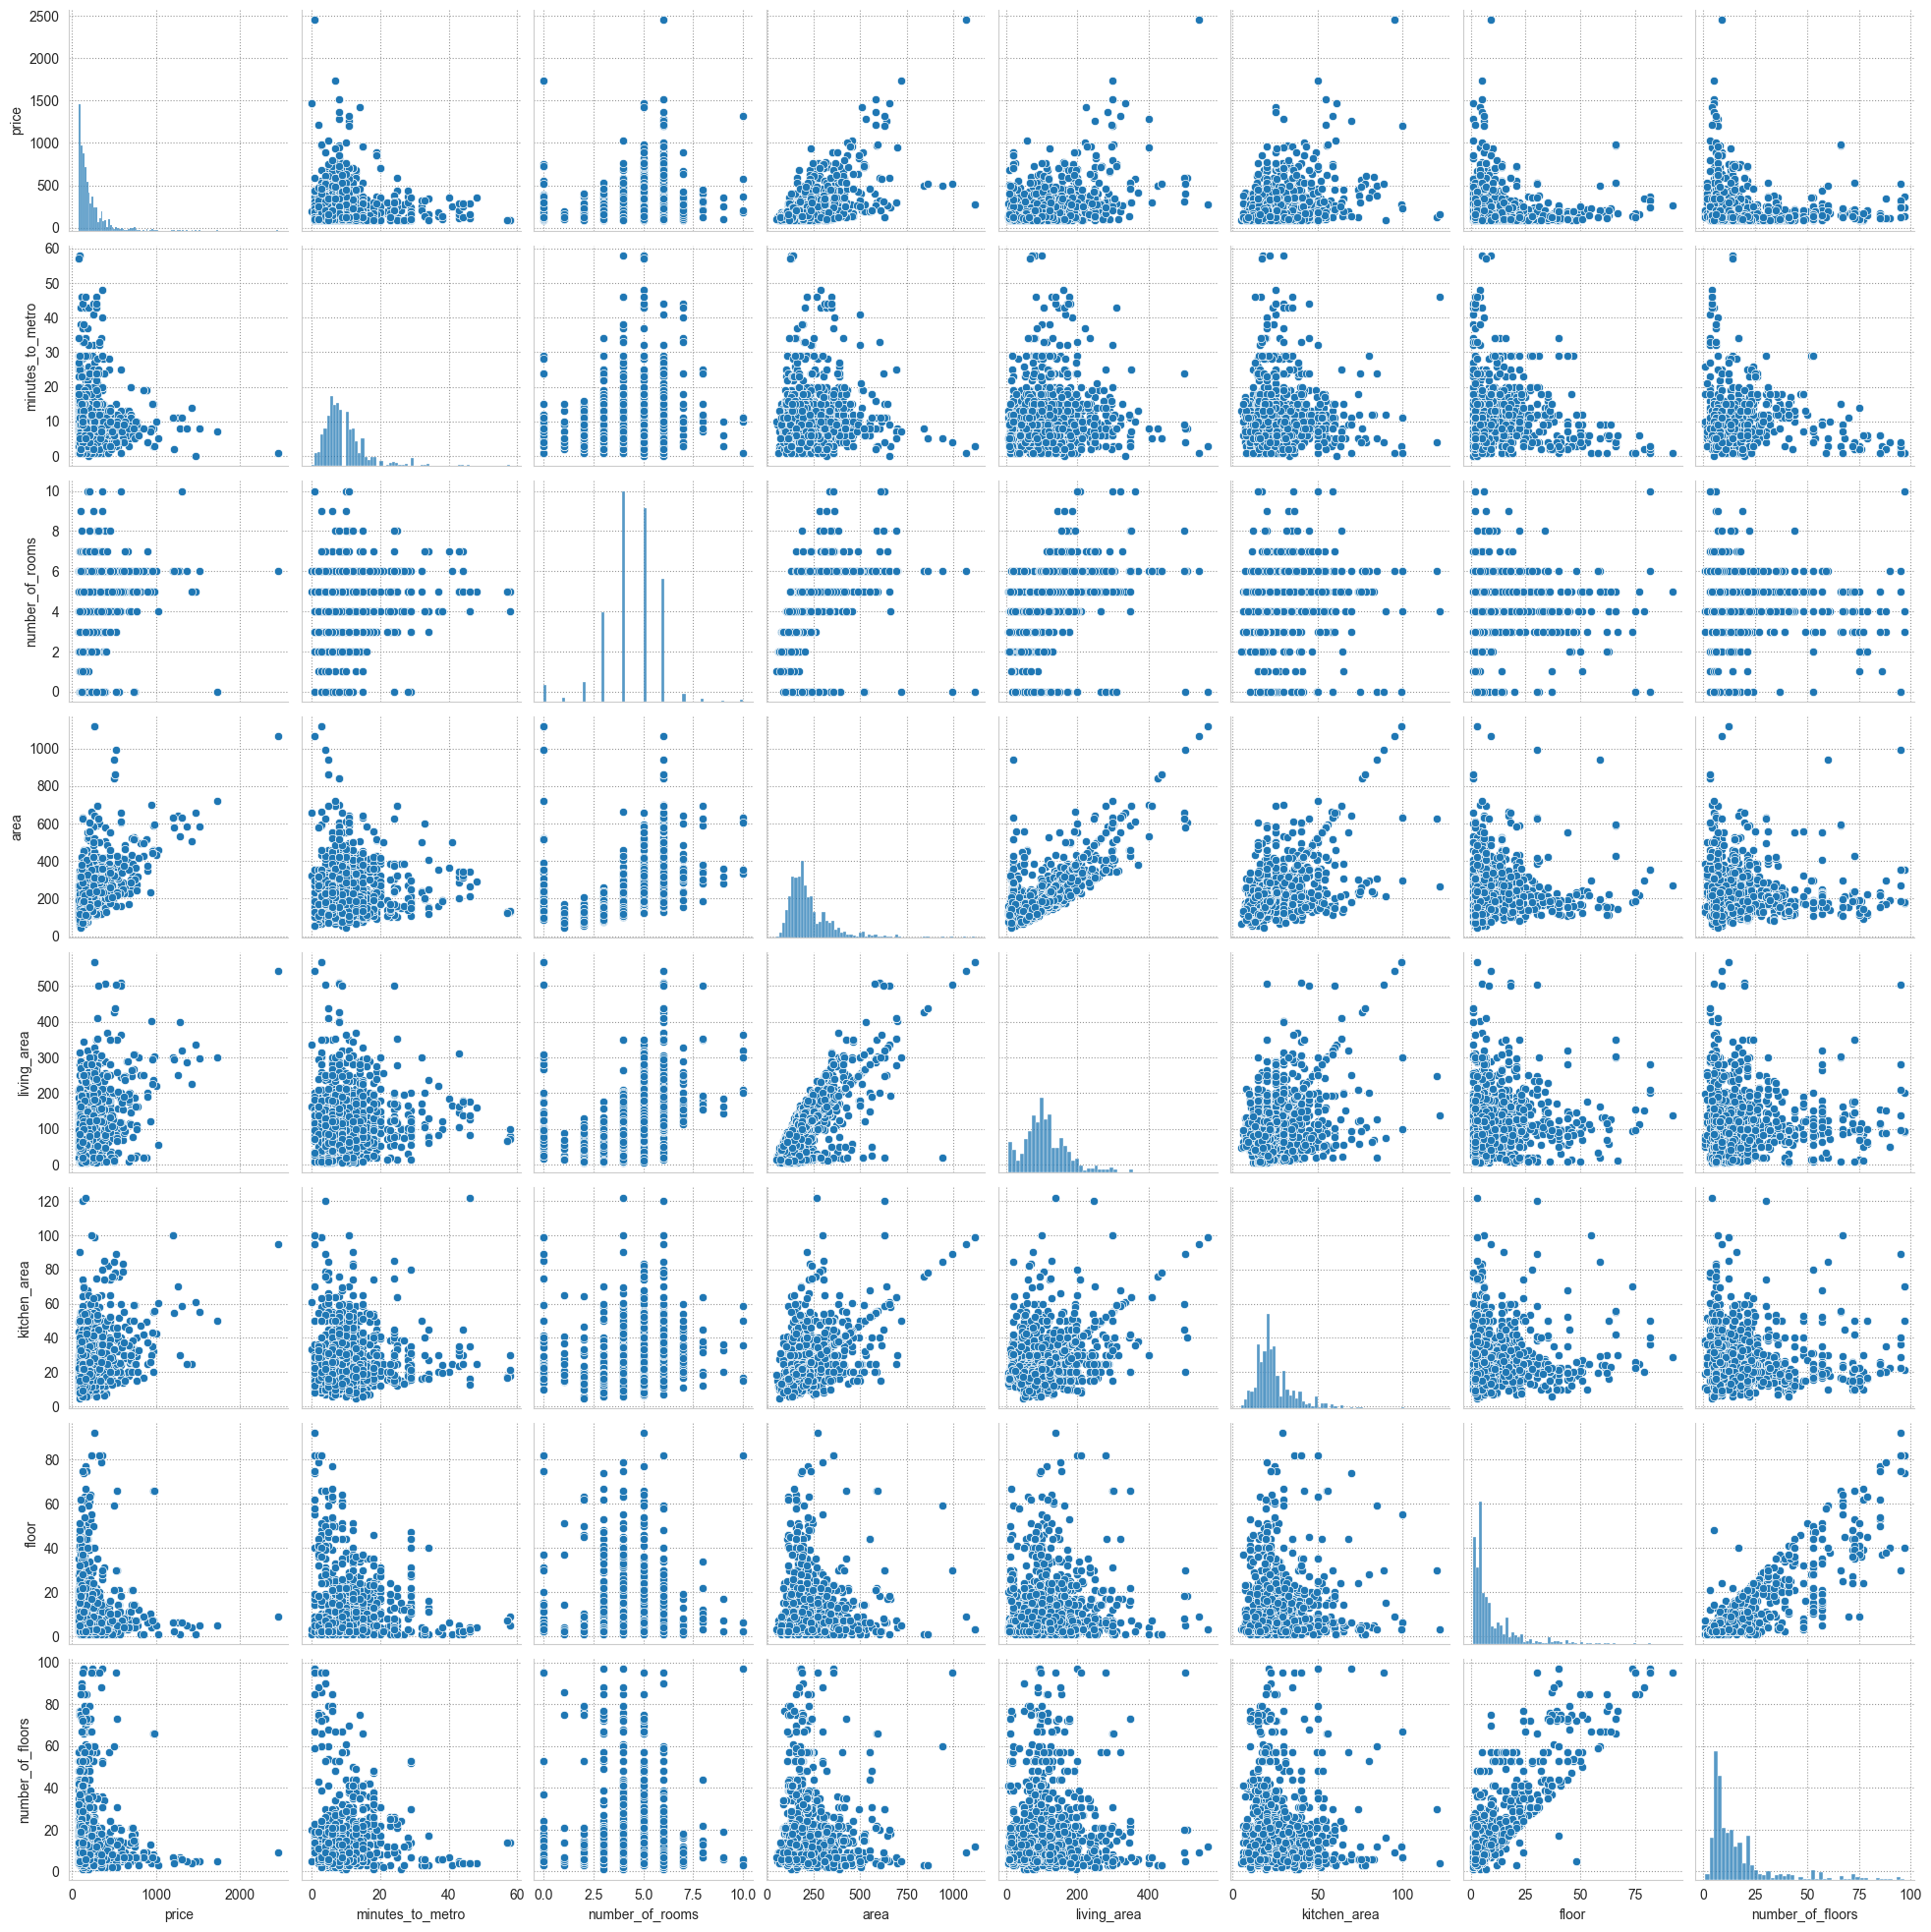

In [4]:
# Исследуем графически зависимость признаков на целевую переменную недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

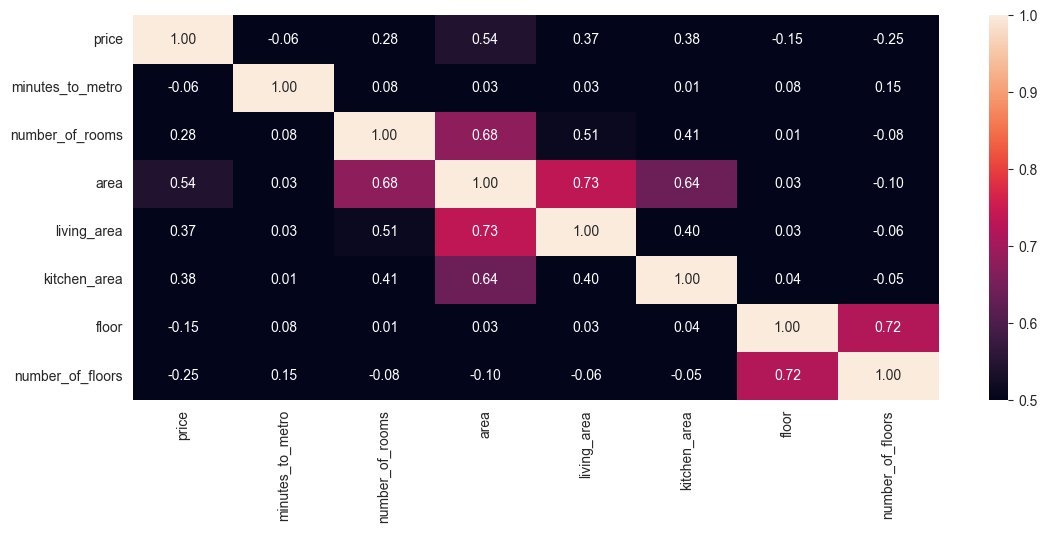

In [5]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

Выводы:
1. графически наблюдается связь цены от минут до метро (minutes_to_metro), чем БЛИЖЕ к метро, тем выше цена.
2. по тепловой карте наблюдается положительная корреляция цены от площади (area, living_area, number_of_rooms).
3. наблюдается корреляция признаков: этажа (floor) от этажности аппартаментов (number_of_floors), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF.
4. наблюдается корреляция признаков: площадь (area) коррелирует с жилой площадью (living_area) и с площадью кухни (kitchen_area), также числом комнат (number_of_rooms), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF

In [6]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.905597
number_of_rooms,7.766630
area,17.115924
living_area,9.035493
kitchen_area,7.643415
floor,6.191350
number_of_floors,6.872840


In [7]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'number_of_floors']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.296103
area,2.529778
floor,1.584655


Вывод: для элитной недвижимости три признака оказались менее 5, то есть с этими признаками можно работать

In [8]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,2240,2240,2240
unique,1,203,4
top,Secondary,Спортивная,Designer
freq,2240,122,1341


Выводы:
1. у нас всего 1 тип аппартаментов в датасете - вторичка, поэтому нет смысла учитывать это как признак
2. у нас всего 4 вида ремонта в датасете
3. элитная недвижимость расположена только вблизи третий всех станций метро

In [9]:
StatCriteria().kruskal(df, 'metro_station', 'price')

kruskal
statistic = 682.283
Медианы всех групп не равны (p-value = 0.000).


In [10]:
StatCriteria().kruskal(df, 'renovation', 'price')

kruskal
statistic = 41.092
Медианы всех групп не равны (p-value = 0.000).


Вывод: на стоимость elite недвижимости влияют все категориальные переменные такие как:
1. metro_station,
2. renovation,

поэтому их все придётся учитывать при проведении регрессии.

In [11]:
df['renovation'] = Encoder().labelEncoder(df['renovation'])
df['metro_station'], _ = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])

In [12]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,360.00000,Secondary,152.947382,29,5,297.5,152.5,31.3,28,53,2
1,270.00000,Secondary,182.177927,7,4,316.0,161.9,32.8,6,6,1
2,256.38075,Secondary,235.537599,12,4,170.8,130.0,30.0,5,12,1
3,140.00000,Secondary,233.903996,4,5,201.0,156.0,25.0,3,5,2
4,732.00000,Secondary,303.154299,7,6,524.0,267.0,50.0,14,15,3


In [15]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

In [16]:
# Применяем готовую линейную регрессию из библиотеки statsmodels
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     236.2
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          9.07e-219
Time:                        13:46:47   Log-Likelihood:                -888.71
No. Observations:                1680   AIC:                             1791.
Df Residuals:                    1673   BIC:                             1829.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
metro_station        1.1419      0.060  

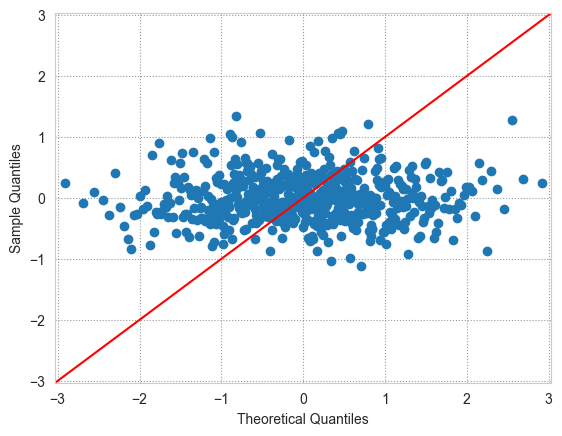

In [17]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

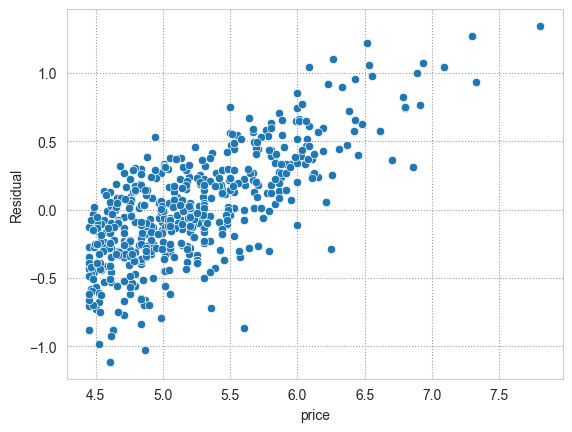

In [18]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

In [19]:
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test, alpha=0.01)
residuals = y_test - y_pred

R²: 0.487
MAE: 0.32
MAPE: 6%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
metro_station: 0.90
minutes_to_metro: -0.00
area: 1.68
floor: -0.00
number_of_floors: -0.00
renovation: -0.00


Выводы: не влияют minutes_to_metro, floor, number_of_floor